In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
from flask import Flask, render_template, url_for, request, redirect
from flask_sqlalchemy import SQLAlchemy
from scipy import stats
from sqlalchemy import create_engine
import sqlite3
#import Correlation as corr
import dbexcel
app = Flask(__name__)
app.config['SQLALCHEMY_DATABASE_URI'] = 'sqlite:///gunpermit.db' # three slashes for relative path. 4 for absolute
db = SQLAlchemy(app)
engine=create_engine('sqlite:///gunpermit.db')
c=engine.connect()
connection = sqlite3.connect('gunpermit.db')

C:\Users\crazy\anaconda3\lib\site-packages\flask_sqlalchemy\__init__.py:835: FSADeprecationWarning: SQLALCHEMY_TRACK_MODIFICATIONS adds significant overhead and will be disabled by default in the future.  Set it to True or False to suppress this warning.
  'SQLALCHEMY_TRACK_MODIFICATIONS adds significant overhead and '


In [14]:
guns={}
shootings={}
gun_totals=[]
for year in range(1999,2020):
    for month in range(1,13):
        shootings[str(month) + "/" + str(year)] = 0
        test = "SELECT COUNT( date) FROM mass_shootings  WHERE date LIKE {question_one} AND date LIKE {question_two}".format(question_one="'"+str(month)+"%'",question_two="'%"+str(year)[2::]+"'")
        permits_sold = "SELECT handgun, long_gun, totals FROM permit WHERE month LIKE {question_one} AND month LIKE {question_two} AND totals <> 0".format(question_one="'"+str(month)+"%'",question_two="'%"+str(year)[2::]+"'")
        x=c.execute(permits_sold).fetchall()
        shootings[str(month) + "/" + str(year)] += c.execute(test).fetchall()[0][0]
        
        z=(sum([pair[0] for pair in x]))
        k=sum([pair[1] for pair in x])
        p=sum([pair[2] for pair in x])
        gun_totals=(z,k,p)
        guns[str(month) + "/" + str(year)]=gun_totals
total_guns=[]
hand_guns=[]
long_guns=[]
mass_shootings=[]
for year in range(1999,2020):
    for month in range(1,13):
        total_guns+=[guns.get(str(month) + "/" + str(year))[2]]
        hand_guns += [guns.get(str(month) + "/" + str(year))[0]]
        long_guns += [guns.get(str(month) + "/" + str(year))[1]]
        mass_shootings+=[shootings.get(str(month) + "/" + str(year))]
long_guns_array=np.array(long_guns)
total_guns_array=np.array(total_guns)
hand_guns_array=np.array(hand_guns)
mass_shootings_array=np.array(mass_shootings)

In [15]:
c.execute("DROP TABLE IF EXISTS exp_results")
c.execute('CREATE TABLE exp_results( gun TEXT, p_value REAL, r_value REAL)')

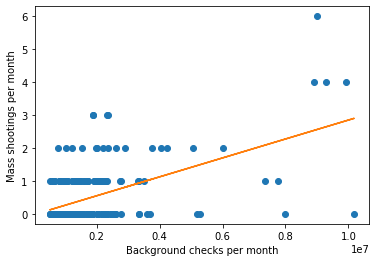

r squared value: 0.28284770471485576
p-value: 8.393011580639094e-20


In [16]:
total_guns_array=total_guns_array.flatten()
plt.plot(total_guns_array.reshape(-1,1),mass_shootings_array,"o")
m, b = np.polyfit(total_guns_array, mass_shootings_array, 1)
model=LinearRegression()
model.fit(total_guns_array.reshape(-1,1),mass_shootings_array)
r_sq = model.score(total_guns_array.reshape(-1,1), mass_shootings_array )
plt.plot(total_guns_array,model.predict(total_guns_array.reshape(-1,1)),)
plt.ylabel("Mass shootings per month")
plt.xlabel("Background checks per month")
plt.show()
statement='INSERT INTO exp_results VALUES(?, {p_value}, {r_value} )'.format( p_value=stats.pearsonr(total_guns_array, mass_shootings_array)[1],r_value=r_sq)
c.execute(statement, "total_guns")
print("r squared value:",r_sq)
print("p-value:", stats.pearsonr(total_guns_array, mass_shootings_array)[1])


r squared value: 0.27202609469133365
p-value: 5.561737042383619e-19


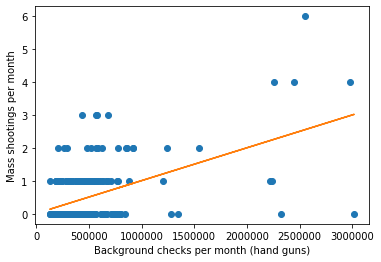

In [17]:
hand_guns_array=hand_guns_array.flatten()
#c=corr.Correlation(hand_guns_array,mass_shootings_array)
plt.plot(hand_guns_array.reshape(-1,1),mass_shootings_array,"o")
m, b = np.polyfit(hand_guns_array, mass_shootings_array, 1)
plt.ylabel("Mass shootings per month")
plt.xlabel("Background checks per month (hand guns)")
model=LinearRegression()
model.fit(hand_guns_array.reshape(-1,1),mass_shootings_array)
r_sq = model.score(hand_guns_array.reshape(-1,1), mass_shootings_array )
plt.plot(hand_guns_array,model.predict(hand_guns_array.reshape(-1,1)))
statement='INSERT INTO exp_results VALUES(?, {p_value}, {r_value} )'.format( p_value=stats.pearsonr(hand_guns_array, mass_shootings_array)[1],r_value=r_sq)
c.execute(statement, "hand_guns")
print("r squared value:",r_sq)
print("p-value:", stats.pearsonr(hand_guns_array, mass_shootings_array)[1])


r squared value: 0.12827192605281834
p-value: 4.842643508315446e-09


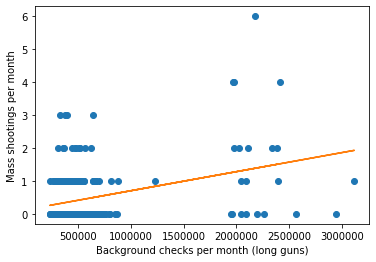

In [18]:
long_guns_array=long_guns_array.flatten()
#c=corr.Correlation(long_guns_array,mass_shootings_array)
plt.plot(long_guns_array.reshape(-1,1),mass_shootings_array,"o")
m, b = np.polyfit(long_guns_array, mass_shootings_array, 1)
model=LinearRegression()
model.fit(long_guns_array.reshape(-1,1),mass_shootings_array)
r_sq = model.score(long_guns_array.reshape(-1,1), mass_shootings_array )
plt.ylabel("Mass shootings per month")
plt.xlabel("Background checks per month (long guns)")
plt.plot(long_guns_array,model.predict(long_guns_array.reshape(-1,1)))
statement='INSERT INTO exp_results VALUES(?, {p_value}, {r_value} )'.format( p_value=stats.pearsonr(long_guns_array, mass_shootings_array)[1],r_value=r_sq)
c.execute(statement, "long_guns")
print("r squared value:",r_sq)
print("p-value:", stats.pearsonr(long_guns_array, mass_shootings_array)[1])

In [19]:
c.execute('SELECT * FROM exp_results').fetchall
  


<bound method ResultProxy.fetchall of <sqlalchemy.engine.result.ResultProxy object at 0x000002B7CF3DA988>>

In [20]:
def prediction(x,y,z):
    model = LinearRegression()
    r_shaped = x.reshape(-1,1)
    model.fit(r_shaped, y)
    return model.coef_[0]*z+model.intercept_

In [21]:
print("Average number of guns sold/month: ",total_guns_array.mean())

Average number of guns sold/month:  1696405.0


In [22]:

prediction(total_guns_array,mass_shootings_array,1000000)

0.2643336181377016

In [23]:
prediction(total_guns_array,mass_shootings_array,total_guns_array.mean())


0.4642857142857143

In [24]:
prediction(total_guns_array,mass_shootings_array,2000000)

0.5514540382208611